In [23]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline 

## Sample Submission

In [5]:
sample_sub = pd.read_csv("./datasets/train_val/sample_submission.csv")

In [6]:
sample_sub.describe()

,ImageId,EncodedPixels
count,88486,88486
unique,88486,1
top,9d3cd0de1.jpg,1 2
freq,1,88486


In [10]:
sample_sub[sample_sub["ImageId"] == "9d3cd0de1.jpg"]

,ImageId,EncodedPixels
54267,9d3cd0de1.jpg,1 2


In [41]:
# 14 unwanted test images
unwanted_test_images = ['13703f040.jpg',
 '14715c06d.jpg',
 '33e0ff2d5.jpg',
 '4d4e09f2a.jpg',
 '877691df8.jpg',
 '8b909bb20.jpg',
 'a8d99130e.jpg',
 'ad55c3143.jpg',
 'c8260c541.jpg',
 'd6c7f17c7.jpg',
 'dc3e7c901.jpg',
 'e44dffe88.jpg',
 'ef87bad36.jpg',
 'f083256d8.jpg',]

In [43]:
print("Submission ids", len(sample_sub["ImageId"].tolist()))
print("Unwanted", len(unwanted_test_images))

# Check if any unwanted images are in sample submission csv
len(np.setdiff1d(sample_sub['ImageId'].unique(), unwanted_test_images, assume_unique=True))


Submission ids 88486
Unwanted 14


88486

## Train Ship Segmentations

In [ ]:
train_ship_segmentations_df = pd.read_csv("./datasets/train_val/train_ship_segmentations.csv")
print(train_ship_segmentations_df.count())
train_ship_segmentations_df.describe()

In [135]:
print("Images with no ship")
train_ship_segmentations_df[train_ship_segmentations_df["EncodedPixels"].isnull()].describe()

Images with no ship


,ImageId,EncodedPixels
count,75000,0.0
unique,75000,0.0
top,39825b977.jpg,NaN
freq,1,NaN


In [136]:
# Corrupted image
train_ship_segmentations_df.loc[train_ship_segmentations_df["ImageId"] == "6384c3e78.jpg"]

,ImageId,EncodedPixels
50949,6384c3e78.jpg,NaN


In [137]:
# Remove corrupted image
train_ship_segmentations_df = train_ship_segmentations_df.loc[train_ship_segmentations_df["ImageId"] != "6384c3e78.jpg"]
train_ship_segmentations_df.describe()                                                   

,ImageId,EncodedPixels
count,131029,56030
unique,104069,56030
top,73361816c.jpg,408822 3 409585 8 410349 12 411112 18 411875 2...
freq,15,1


In [145]:
train_ship_segmentations_df_null = train_ship_segmentations_df["EncodedPixels"].isnull()
nulls_df = train_ship_segmentations_df[~train_ship_segmentations_df_null]
nulls_sample_df = nulls_df.sample(frac=0.99) # remove frac % of empty images
train_ship_segmentations_df = train_ship_segmentations_df.loc[~train_ship_segmentations_df["ImageId"].isin(nulls_sample_df["ImageId"])]

# train_ship_segmentations_df = train_ship_segmentations_df.loc[train_ship_segmentations_df["EncodedPixels"].isnull()].sample(frac=0.5)
train_ship_segmentations_df.shape

(56780, 2)

## Actual Submission

In [87]:
submission_1 = pd.read_csv("~/Downloads/submission_20180820T0329.csv")
submission = pd.read_csv("~/Downloads/submission_20180825T0545.csv")
print(submission_1.head())
submission_1.describe()


         ImageId                                      EncodedPixels
0  0001124c7.jpg                                                NaN
1  000194a2d.jpg  362787 4 363554 6 364322 6 365090 7 365858 8 3...
2  000194a2d.jpg  6998 54 7062 9 7741 103 8467 3 8482 133 9232 1...
3  0001b1832.jpg                                                NaN
4  00052ed46.jpg                                                NaN


,ImageId,EncodedPixels
count,99150,28208
unique,88486,28208
top,f7e6819bb.jpg,139916 1 140682 5 141449 7 142214 11 142964 30...
freq,14,1


In [86]:
print(submission.head())
submission.describe()

         ImageId                                      EncodedPixels
0  0001124c7.jpg                                                NaN
1  000194a2d.jpg  362020 5 362787 7 363554 8 364322 8 365091 8 3...
2  000194a2d.jpg  259004 4 259771 6 260539 8 261306 9 262074 9 2...
3  0001b1832.jpg                                                NaN
4  00052ed46.jpg                                                NaN


,ImageId,EncodedPixels
count,106254,38947
unique,88486,38947
top,f7e6819bb.jpg,398812 6 399580 6 400348 6 401116 6 401884 7 4...
freq,13,1


In [88]:
print(70942/99150)
submission_1[submission_1["EncodedPixels"].isnull()].describe()

0.7155017650025214


,ImageId,EncodedPixels
count,70942,0.0
unique,70942,0.0
top,916cd8f77.jpg,NaN
freq,1,NaN


In [85]:
print(38947/106254)
print(67307/106254)
submission[submission["EncodedPixels"].isnull()].describe()


0.366546200613624
0.633453799386376


,ImageId,EncodedPixels
count,67307,0.0
unique,67307,0.0
top,916cd8f77.jpg,NaN
freq,1,NaN


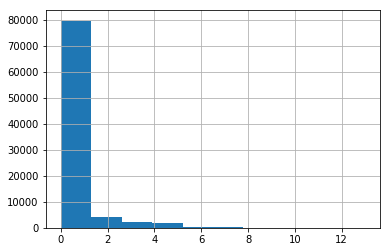

In [27]:
submission['ships'] = submission['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = submission.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
# unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
#                                                                os.stat(os.path.join(train_image_dir, 
#                                                                                     c_img_id)).st_size/1024)
# unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
# unique_img_ids['file_size_kb'].hist()
unique_img_ids['ships'].hist()
# unique_img_ids.sample(10)

In [ ]:
submission_1['ships'] = submission_1['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = submission_1.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
# unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
#                                                                os.stat(os.path.join(train_image_dir, 
#                                                                                     c_img_id)).st_size/1024)
# unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
# unique_img_ids['file_size_kb'].hist()
unique_img_ids['ships'].hist()

## Corrected Submission

In [5]:
# df = sub_blanks.replace(r'^\s*$', np.nan, regex=True)
# df.head()

In [4]:
# df.to_csv("submission_20180817T1649_2.csv", index=False)

## Remove duplicate pixels

In [2]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [3]:
sub_df = pd.read_csv("~/Downloads/submission_20180825T0545.csv")
sub_df.describe()
sub_df.head()

,ImageId,EncodedPixels
0,0001124c7.jpg,NaN
1,000194a2d.jpg,362020 5 362787 7 363554 8 364322 8 365091 8 3...
2,000194a2d.jpg,259004 4 259771 6 260539 8 261306 9 262074 9 2...
3,0001b1832.jpg,NaN
4,00052ed46.jpg,NaN


In [5]:
multiple_instances_mask = sub_df.duplicated(subset="ImageId", keep=False)
multiple_instances_df = sub_df[multiple_instances_mask]
multiple_instances_df.head()

,ImageId,EncodedPixels
1,000194a2d.jpg,362020 5 362787 7 363554 8 364322 8 365091 8 3...
2,000194a2d.jpg,259004 4 259771 6 260539 8 261306 9 262074 9 2...
23,0015a4f8b.jpg,551625 7 552393 8 553161 9 553929 9 554696 10 ...
24,0015a4f8b.jpg,295254 5 296022 6 296789 8 297557 9 298325 10 ...
25,0015a4f8b.jpg,207422 5 208188 7 208956 7 209724 7 210492 7 2...


In [8]:
example_mask = multiple_instances_df["ImageId"] == "443cfdb6a.jpg"
image_id_df = multiple_instances_df[example_mask]
print(image_id_df)

             ImageId                                      EncodedPixels
28277  443cfdb6a.jpg  6563 8 7328 13 8093 17 8860 18 9626 21 10391 2...
28278  443cfdb6a.jpg  365829 11 366595 14 367361 17 368128 19 368894...
28279  443cfdb6a.jpg  455331 16 456098 21 456865 24 457633 24 458401...
28280  443cfdb6a.jpg  461456 14 462224 15 462992 15 463760 15 464528...


In [7]:
unique_ids_multiple_instances = multiple_instances_df.ImageId.unique()
print("Checking ", len(unique_ids_multiple_instances), "unique images")
out_pred_rows = []
for image_id in unique_ids_multiple_instances:
    
#     print(image_id)
    # Image masks in RLE
    img_masks = multiple_instances_df.loc[multiple_instances_df['ImageId'] == image_id, 'EncodedPixels'].tolist()
#     print("Initial", img_masks)
    
    # Mask array placeholder
    mask_array = np.zeros([768, 768, len(img_masks)],dtype=np.uint8)

    # Build mask array
    for index, mask in enumerate(img_masks):
        mask_array[:,:,index] = rle_decode(mask, [768, 768])

#     print("mask_array shape", mask_array.shape)
    loop_range = np.array(mask_array).shape[-1] - 1
#     print("loop_range", np.arange(loop_range))
    
    # Check for overlap and remove overlapped pixels
    for i in np.arange(loop_range):
#         print("i: ", i)
        mask = mask_array[:,:,i]
        
        loop_j = np.arange(loop_range-i)+i+1
#         print(loop_j)
        for j in loop_j:
#             print("j: ", j)
            next_mask = mask_array[:,:,j]
            
            index_of_overlap = np.logical_and(mask, next_mask)
            if any(index_of_overlap.flatten()):
                    print("OVERLAP ", image_id)
                    next_mask[index_of_overlap] = 0
#             else: 
#                 print("NO OVERLAP")
        
    # Convert back into RLE encoding
    re_encoded_to_rle_list = []
    for i in np.arange(np.array(mask_array).shape[-1]):
        boolean_mask = mask_array[:,:,i]
        re_encoded_to_rle = rle_encode(boolean_mask)
        re_encoded_to_rle_list.append(re_encoded_to_rle)

#     print("---------------------")

#     print("Ending", re_encoded_to_rle_list)
    
    if len(re_encoded_to_rle_list) == 0:
        out_pred_rows += [{'ImageId': image_id, 'EncodedPixels': None}]
    else:
        for rle_mask in re_encoded_to_rle_list:
            out_pred_rows += [{'ImageId': image_id, 'EncodedPixels': rle_mask}]
            
no_overlap_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
    
#     print(no_overlap_df)
    
    
    

Checking  8711 unique images
OVERLAP  443cfdb6a.jpg


AttributeError: 'float' object has no attribute 'split'

In [179]:
        
np.arange(2)+1
        

array([1, 2])

In [175]:
a1 = np.array([[1,1,0,0],
               [1,1,0,0]])
a2 = np.array([[0,0,0,0],
               [0,1,1,0]])
a3 = np.array([[0,1,1,0],
               [0,0,0,0]])
masks = np.zeros([2,4,3])
masks[:,:,0] = a1
masks[:,:,1] = a2
masks[:,:,2] = a3
masks.shape

(2, 4, 3)

In [176]:
# print("Masks", masks)
for index, mask in enumerate(masks):
    for next_mask in masks[index+1:]:
        index_of_overlap = np.logical_and(mask, next_mask)
        if any(index_of_overlap.flatten()):
            next_mask[index_of_overlap] = 0
    
print(masks)

[[[ 1.  0.  0.]
  [ 1.  0.  1.]
  [ 0.  0.  1.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  1.  0.]
  [ 0.  1.  0.]
  [ 0.  0.  0.]]]


In [80]:
index_of_overlap = np.logical_and(a1,a2,a3)
index_of_overlap

a2[index_of_overlap] = 0
a3[index_of_overlap] = 0

In [81]:
print(a1)
print(a2)
print(a3)

[[0 0 0]
 [1 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
